### Prepare VOR data for analysis

#### Package inputs

In [1]:
import os
import pandas as pd
import geopandas as gpd
import re
import numpy as np
from shapely.geometry import Point, LineString, shape, Polygon, MultiPoint

#### Specify parameters

##### Specify input paths

In [2]:
# set working directory to root
os.chdir('/mnt/c/Users/Sean.Kearney/git_repos/cper_hls_veg_models')

# annual VOR data from all pastures
base_vor_dir = '/mnt/t/4-DataCatalog/CARM/VOR/'
vor_june_f = os.path.join(base_vor_dir, 'CARM_VOR_JUN_cln_attr_ALL_HiLo2022-10-17.csv')
vor_oct_f = os.path.join(base_vor_dir, 'CARM_VOR_OCT_cln_attr_ALL_HiLo2022-10-19.csv')

# weekly VOR data from CARM pastures
vor_wkly_dict = {}
for y in range(2014, 2023):
    vor_wkly_dict[y] = 'data/ground/vor/Weekly_VOR_{}_simp.csv'.format(str(y))

# cper pastures shapefile
cper_f = '/mnt/t/3-GIS/CPER/Layers/Pasture_Boundaries/Shapefiles/cper_pastures_2022_w_exclosures_spk.shp'

# transects shapefile
transects_f = "/mnt/t/3-GIS/CPER/Layers/Plots_Transects/CPER_VOR_Transects_all_2020_Oct14.shp"

##### Specify species and other cleaning parameters

In [3]:
# list of species to remove from datasets
spp_rem = ['OPPO', 'ATCA', 'GUSA', 'EREF', 'ARFR', 'ERNA', 'KRLA', 'YUGL']

# dictionary of species names to change
spp_chg = {"ANT": "BARE", "ARME": "ARPO", "CACU": "CADU", "CAIN": "CANE", "CELA": "KRLA", "CMRI": "CRMI",
           "EBNU": "EVNU", "LYGU": "LYJU", "SIAB": "SAIB", "SIHY": "ELEL", "STCO": "HECO",
           "UNK": "UNKN", "UNKF": "UNFB", "UKNF": "UNFB", "VUO": "VUOC", "BA": "BARE", "BU": "BUDA",
           "CA": "CADU", "HE": "HECO", "VU": "VUOC", "BNO": "BOGR", "BRTI": "BRTE", "LITTT": "LITT",
           "ALIT": "ALTE", "BGOR": "BOGR", "VARE": "BARE", "ALTI": "ALTE", "AT": "ATCA", "BR": "BRTE",
           "KLI": "KRLA", "LOPP": "OPPO", "PA": "PASM", "POASM": "PASM", "SP": "SPAI", "VO": "VUOC",
           "oldforb": "FORB", "BO": "BOBU", "std": "SD", "stde": "SD", "bu": "BUDA", "vo": "VUOC", "vouc": "VUOC",
           "AFRF": "ARFR", "LIT": "LITT", "lit": "LITT"}

# coefficients for VOR to biomass regression
coef_intcp = 32.9
coef_low = 133.6
coef_hi = 23.7

# set experimental unit to plot' or 'transect'
exp_unit = "plot"

# set filters for VOR
max_vor = 50
max_sd = 2.5

# create transect pasture renaming dictionary
trans_name_dict = {
    'NH': '10S',
    '7se': '7SE',
    '31w': '31W',
    '26w': '26W',
    '25nw': '25NW',
    '17s': '17S',
    '18s': '18S',
    '19n': '19N',
    '21n': '21N',
    '22SW': '22W'
}

# create vor pasture renaming dictionary
vor_name_dict = {
    '18S_burn': '18S',
    '7SE_salt': '7SE',
    'NH': '10S',
    '20NW_saltflat': '20NW'
}

# create vor plot renaming dictionary
vor_plot_dict = {
    '4_burn': '4'
}

#### Prepare all variable objects

##### Read in datasets

In [4]:
# read in weekly VOR csv's
for i,k in enumerate(vor_wkly_dict):
    if i == 0:
        df_vor_wkly = pd.read_csv(vor_wkly_dict[k])
    else:
        df_vor_wkly = pd.concat([df_vor_wkly, pd.read_csv(vor_wkly_dict[k], encoding='cp1252')])

In [5]:
# read in annual VOR csv's
df_vor_june = pd.read_csv(vor_june_f, usecols=np.arange(1, 20), engine='python')
df_vor_oct = pd.read_csv(vor_oct_f, usecols=np.arange(1, 20), engine='python')

In [6]:
# read in shapefiles
gdf_cper = gpd.read_file(cper_f)
gdf_transects = gpd.read_file(transects_f)

##### Clean up and prepare transects

In [7]:
# rename transect pasture names to match pasture shapefile
gdf_transects['PastureNm'] = gdf_transects['PastureNm'].apply(
    lambda x: trans_name_dict[x] if x in trans_name_dict.keys() else x)

# remove prefixes for transect names
gdf_transects['Transect'] = gdf_transects['Transect'].apply(
    lambda x: re.sub("P", "", re.sub("T", "", str(x))))

# create unique transect id's
gdf_transects['Id'] = gdf_transects.apply(
    lambda x: x['PastureNm'] + "_" + x['Plot_Num'] + "_" + str(x['Transect']),
    axis=1)

# create unique plot id's
gdf_transects['Id_plot'] = gdf_transects.apply(lambda x: x['PastureNm'] + "_" + x['Plot_Num'], axis=1)

# create transect geometry from coordinates
#gdf_transects['geometry'] = gdf_transects['geometry'].apply(lambda x: x.coords[0])

# create plot-scale geodataframe using convex hull and buffer by 15 m
gdf_plots = gdf_transects.groupby(['Id_plot'])['geometry'].apply(lambda x: MultiPoint(x.tolist()).convex_hull)
gdf_plots = gpd.GeoDataFrame(gdf_plots, geometry='geometry', crs=gdf_transects.crs).buffer(15)

# convert transect-scale geodataframe to polygon using convex hull and buffer by 15 m
gdf_transects = gdf_transects.groupby(['Id'])['geometry'].apply(lambda x: MultiPoint(x.tolist()).convex_hull)
gdf_transects = gpd.GeoDataFrame(gdf_transects, geometry='geometry', crs=gdf_plots.crs).buffer(15)

##### Clean up and prepare weekly VOR

In [8]:
# drop unneccesary columns
df_vor_wkly = df_vor_wkly.drop(columns=['V_E_F', 'G_UG']).copy()

### RENAMING
# rename pastures to match shapefiles
df_vor_wkly['Pasture'] = df_vor_wkly['Pasture'].apply(lambda x: vor_name_dict[x] if x in vor_name_dict.keys() else x)
# rename plots to match shapefiles
df_vor_wkly['Plot'] = df_vor_wkly['Plot'].apply(lambda x: vor_plot_dict[x] if x in vor_plot_dict.keys() else x)
# add "P" to plot number and convert to string
df_vor_wkly['Plot'] = "P" + df_vor_wkly['Plot'].astype('str')

### DATES
# get all week data into one place and drop strangely named week column
df_vor_wkly.loc[df_vor_wkly['Week'].isnull(), 'Week'] = df_vor_wkly['ï»¿Week'][df_vor_wkly['Week'].isnull()]
df_vor_wkly = df_vor_wkly.drop(columns=['ï»¿Week']).copy()
# convert Date column to datetime
df_vor_wkly['Date'] = pd.to_datetime(df_vor_wkly['Date'])
# add Year column
df_vor_wkly['Year'] = df_vor_wkly['Date'].dt.year
# get date as integer timestamp for averaging later
df_vor_wkly['Date_as_int'] = df_vor_wkly['Date'].values.astype(np.int64)

### FIX 'Low' READINGS
# convert Low readings of 'dung' to zeros
df_vor_wkly.loc[df_vor_wkly['Low'] == 'dung', 'Low'] = 0
# convert Low readings to numeric
df_vor_wkly['Low'] = df_vor_wkly['Low'].astype('float')

### FIX SPECIES
# remove any spaces in species names
df_vor_wkly['Spp'] = df_vor_wkly['Spp'].apply(lambda x: re.sub(' ', '', str(x)))  
df_vor_wkly['H.Spp'] = df_vor_wkly['H.Spp'].apply(lambda x: re.sub(' ', '', str(x)))  
# replace erroneous species names
for name_old, name_new in spp_chg.items():
    df_vor_wkly['Spp'] = df_vor_wkly['Spp'].replace(name_old, name_new)  
    df_vor_wkly['H.Spp'] = df_vor_wkly['H.Spp'].replace(name_old, name_new)  
# convert all species names to upper case
df_vor_wkly['Spp'] = df_vor_wkly['Spp'].str.upper()  
df_vor_wkly['H.Spp'] = df_vor_wkly['H.Spp'].str.upper()  

### REMOVING OBSERVATIONS
# remove nonsensical data
df_vor_wkly = df_vor_wkly[~(df_vor_wkly['Low'] > df_vor_wkly['High'])].copy()
# remove observations where Comments column indicates
df_vor_wkly = df_vor_wkly[~(df_vor_wkly['Comments'].str.contains("emove", na=False))]
# remove non-herbaceous species
df_vor_wkly = df_vor_wkly[~(df_vor_wkly['Spp'].isin(spp_rem))]
df_vor_wkly = df_vor_wkly[~(df_vor_wkly['H.Spp'].isin(spp_rem))]

### FIX GREEN AND BROWN READINGS
# make all 'G' and 'B' readings lowercase
df_vor_wkly.loc[df_vor_wkly['G_B'] == 'G', 'G_B'] = 'g'
df_vor_wkly.loc[df_vor_wkly['G_B'] == 'B', 'G_B'] = 'b'

### CREATE ID - ONLY POSSIBLE AT PLOT LEVEL FOR WEEKLY DATA
df_vor_wkly['Id'] = df_vor_wkly['Pasture'] + "_" + df_vor_wkly['Plot']

##### Clean up and prepare June VOR

In [9]:
### INITIAL CLEANUP
# drop any rows where all columns are NA
df_vor_june = df_vor_june.dropna(how='all').copy()

### RENAMING
# rename pastures to match shapefiles
df_vor_june['Pasture'] = df_vor_june['Pasture'].apply(lambda x: vor_name_dict[x] if x in vor_name_dict.keys() else x)
# add "P" to plot number and cover to string
df_vor_june['Plot'] = "P" + df_vor_june['Plot'].astype('int').astype('str')

### DATES
# fix date issue in 2020 data
df_vor_june.loc[(df_vor_june['Year'] == 2020) & (df_vor_june['SamplingDate'] == '11-Jun'), 'SamplingDate'] = '6/11/2020'
# convert Year column to integer
df_vor_june['Year'] = df_vor_june['Year'].astype(int)
# convert SamplingDate column to datetime
df_vor_june['SamplingDate'] = pd.to_datetime(df_vor_june['SamplingDate'])
# fill any missing dates with June 12th of that year
df_vor_june.loc[df_vor_june['SamplingDate'].isnull(), 
                'SamplingDate'] = pd.to_datetime('6/12/' + df_vor_june.loc[df_vor_june['SamplingDate'].isnull(), 'Year'].astype(str))
# manually fix date errors
df_vor_june.loc[(df_vor_june['Year'] == 2019) & (df_vor_june['SamplingDate'].dt.year == 2013), 
                'SamplingDate'] = pd.to_datetime('2019-6-13')
df_vor_june.loc[(df_vor_june['Year'] == 2018) & (df_vor_june['SamplingDate'].dt.year == 2014), 
                'SamplingDate'] = pd.to_datetime('2018-6-19')
# rename date to match weekly data
df_vor_june = df_vor_june.rename(columns={'SamplingDate': 'Date'})
# get date as integer timestamp for averaging later
df_vor_june['Date_as_int'] = df_vor_june['Date'].values.astype(np.int64)
# get average date by pasture
df_vor_june['Date_mean'] = df_vor_june.groupby(['Year', 'Pasture'])['Date'].transform('mean')
# get average date as integer timestamp for averaging later
df_vor_june['Date_mean_as_int'] = df_vor_june['Date_mean'].values.astype(np.int64)

### FIX SPECIES
# remove any spaces in species names
df_vor_june['East_SppLo'] = df_vor_june['East_SppLo'].apply(lambda x: re.sub(' ', '', str(x)))
df_vor_june['West_SppLo'] = df_vor_june['West_SppLo'].apply(lambda x: re.sub(' ', '', str(x)))
df_vor_june['East_SppHi'] = df_vor_june['East_SppHi'].apply(lambda x: re.sub(' ', '', str(x)))
df_vor_june['West_SppHi'] = df_vor_june['West_SppHi'].apply(lambda x: re.sub(' ', '', str(x)))

# replace erroneous species names
for name_old, name_new in spp_chg.items():
    df_vor_june['East_SppLo'] = df_vor_june['East_SppLo'].replace(name_old, name_new)  
    df_vor_june['West_SppLo'] = df_vor_june['West_SppLo'].replace(name_old, name_new)
    df_vor_june['East_SppHi'] = df_vor_june['East_SppHi'].replace(name_old, name_new)  
    df_vor_june['West_SppHi'] = df_vor_june['West_SppHi'].replace(name_old, name_new)

# convert all species names to upper case
df_vor_june['East_SppLo'] = df_vor_june['East_SppLo'].str.upper()  
df_vor_june['West_SppLo'] = df_vor_june['West_SppLo'].str.upper()
df_vor_june['East_SppHi'] = df_vor_june['East_SppHi'].str.upper()  
df_vor_june['West_SppHi'] = df_vor_june['West_SppHi'].str.upper()

### SET NULLS WHERE NEEDED
# remove nonsensical observation data
df_vor_june.loc[df_vor_june['East_Low1'] > df_vor_june['East_High1'], ['East_Low1', 'East_High1']] = [np.nan, np.nan]
df_vor_june.loc[df_vor_june['West_Low2'] > df_vor_june['West_High2'], ['West_Low2', 'West_High2']] = [np.nan, np.nan]

# remove non-herbaceous species
df_vor_june.loc[df_vor_june['East_SppLo'].isin(spp_rem), ['East_Low1', 'East_High1']] = [np.nan, np.nan]
df_vor_june.loc[df_vor_june['East_SppHi'].isin(spp_rem), 'East_High1'] = np.nan
df_vor_june.loc[df_vor_june['West_SppLo'].isin(spp_rem), ['West_Low2', 'West_High2']] = [np.nan, np.nan]
df_vor_june.loc[df_vor_june['West_SppHi'].isin(spp_rem), 'West_High2'] = np.nan

### GET FINAL VOR MEANS
# get means of multiple low and high readings
df_vor_june['Low'] = np.nanmean(df_vor_june[['East_Low1', 'West_Low2']], axis=1)
df_vor_june['High'] = np.nanmean(df_vor_june[['East_High1', 'West_High2']], axis=1)

### REMOVE OBSERVATIONS
# remove nonsensical mean data
df_vor_june = df_vor_june[~(df_vor_june['Low'] > df_vor_june['High'])].copy()

### SET ID
if exp_unit == "transect":
    df_vor_june['Id'] = df_vor_june['Pasture'] + "_" + df_vor_june['Plot'] + "_" + df_vor_june['Transect'].astype('str')
elif exp_unit == "plot":
    df_vor_june['Id'] = df_vor_june['Pasture'] + "_" + df_vor_june['Plot']
else:
    print('ERROR! Experimental unit undefined or incorrect. Currently set at:')
    print(exp_unit)

/tmp/ipykernel_4360/151803278.py:68: RuntimeWarning: Mean of empty slice
  df_vor_june['Low'] = np.nanmean(df_vor_june[['East_Low1', 'West_Low2']], axis=1)
/tmp/ipykernel_4360/151803278.py:69: RuntimeWarning: Mean of empty slice
  df_vor_june['High'] = np.nanmean(df_vor_june[['East_High1', 'West_High2']], axis=1)


##### Clean up and prepare October VOR

In [10]:
### INITIAL CLEANUP
# drop any rows where all columns are NA
df_vor_oct = df_vor_oct.dropna(how='all').copy()

### RENAMING
# rename pastures to match shapefiles
df_vor_oct['Pasture'] = df_vor_oct['Pasture'].apply(lambda x: vor_name_dict[x] if x in vor_name_dict.keys() else x)
# add "P" to plot number and cover to string
df_vor_oct['Plot'] = "P" + df_vor_oct['Plot'].astype('int').astype('str')

### DATES
# fix date issue in 2020 data
df_vor_oct.loc[(df_vor_oct['Year'] == 2021) & (df_vor_oct['SamplingDate'] == '10/5/1931'), 'SamplingDate'] = '10/5/2021'
# convert Year column to integer
df_vor_oct['Year'] = df_vor_oct['Year'].astype(int)
# convert SamplingDate column to datetime
df_vor_oct['SamplingDate'] = pd.to_datetime(df_vor_oct['SamplingDate'])
# fill any missing dates with oct 12th of that year
df_vor_oct.loc[df_vor_oct['SamplingDate'].isnull(), 
                'SamplingDate'] = pd.to_datetime('10/5/' + df_vor_oct.loc[df_vor_oct['SamplingDate'].isnull(), 'Year'].astype(str))
# rename date to match weekly data
df_vor_oct = df_vor_oct.rename(columns={'SamplingDate': 'Date'})
# get date as integer timestamp for averaging later
df_vor_oct['Date_as_int'] = df_vor_oct['Date'].values.astype(np.int64)
# get average date by pasture
df_vor_oct['Date_mean'] = df_vor_oct.groupby(['Year', 'Pasture'])['Date'].transform('mean')
# get average date as integer timestamp for averaging later
df_vor_oct['Date_mean_as_int'] = df_vor_oct['Date_mean'].values.astype(np.int64)

### FIX SPECIES
# remove any spaces in species names
df_vor_oct['East_SppLo'] = df_vor_oct['East_SppLo'].apply(lambda x: re.sub(' ', '', str(x)))
df_vor_oct['West_SppLo'] = df_vor_oct['West_SppLo'].apply(lambda x: re.sub(' ', '', str(x)))
df_vor_oct['East_SppHi'] = df_vor_oct['East_SppHi'].apply(lambda x: re.sub(' ', '', str(x)))
df_vor_oct['West_SppHi'] = df_vor_oct['West_SppHi'].apply(lambda x: re.sub(' ', '', str(x)))

# replace erroneous species names
for name_old, name_new in spp_chg.items():
    df_vor_oct['East_SppLo'] = df_vor_oct['East_SppLo'].replace(name_old, name_new)  
    df_vor_oct['West_SppLo'] = df_vor_oct['West_SppLo'].replace(name_old, name_new)
    df_vor_oct['East_SppHi'] = df_vor_oct['East_SppHi'].replace(name_old, name_new)  
    df_vor_oct['West_SppHi'] = df_vor_oct['West_SppHi'].replace(name_old, name_new)

# convert all species names to upper case
df_vor_oct['East_SppLo'] = df_vor_oct['East_SppLo'].str.upper()  
df_vor_oct['West_SppLo'] = df_vor_oct['West_SppLo'].str.upper()
df_vor_oct['East_SppHi'] = df_vor_oct['East_SppHi'].str.upper()  
df_vor_oct['West_SppHi'] = df_vor_oct['West_SppHi'].str.upper()

### SET NULLS WHERE NEEDED
# remove nonsensical observation data
df_vor_oct.loc[df_vor_oct['East_Low1'] > df_vor_oct['East_High1'], ['East_Low1', 'East_High1']] = [np.nan, np.nan]
df_vor_oct.loc[df_vor_oct['West_Low2'] > df_vor_oct['West_High2'], ['West_Low2', 'West_High2']] = [np.nan, np.nan]

# remove non-herbaceous species
df_vor_oct.loc[df_vor_oct['East_SppLo'].isin(spp_rem), ['East_Low1', 'East_High1']] = [np.nan, np.nan]
df_vor_oct.loc[df_vor_oct['East_SppHi'].isin(spp_rem), 'East_High1'] = np.nan
df_vor_oct.loc[df_vor_oct['West_SppLo'].isin(spp_rem), ['West_Low2', 'West_High2']] = [np.nan, np.nan]
df_vor_oct.loc[df_vor_oct['West_SppHi'].isin(spp_rem), 'West_High2'] = np.nan

### GET FINAL VOR MEANS
# get means of multiple low and high readings
df_vor_oct['Low'] = np.nanmean(df_vor_oct[['East_Low1', 'West_Low2']], axis=1)
df_vor_oct['High'] = np.nanmean(df_vor_oct[['East_High1', 'West_High2']], axis=1)

### REMOVE OBSERVATIONS
# remove nonsensical mean data
df_vor_oct = df_vor_oct[~(df_vor_oct['Low'] > df_vor_oct['High'])].copy()

### SET ID
if exp_unit == "transect":
    df_vor_oct['Id'] = df_vor_oct['Pasture'] + "_" + df_vor_oct['Plot'] + "_" + df_vor_oct['Transect'].astype('str')
elif exp_unit == "plot":
    df_vor_oct['Id'] = df_vor_oct['Pasture'] + "_" + df_vor_oct['Plot']
else:
    print('ERROR! Experimental unit undefined or incorrect. Currently set at:')
    print(exp_unit)
    
### GET AVERAGE DATE BY ID
df_vor_oct['Date_mean'] = df_vor_oct.groupby(['Id', 'Year', 'Pasture'])['Date'].transform('mean')

/tmp/ipykernel_4360/351838573.py:63: RuntimeWarning: Mean of empty slice
  df_vor_oct['Low'] = np.nanmean(df_vor_oct[['East_Low1', 'West_Low2']], axis=1)
/tmp/ipykernel_4360/351838573.py:64: RuntimeWarning: Mean of empty slice
  df_vor_oct['High'] = np.nanmean(df_vor_oct[['East_High1', 'West_High2']], axis=1)


In [11]:
# get average date by pasture
df_vor_june['Date_mean'] = df_vor_june.groupby(['Year', 'Pasture'])['Date'].transform('mean')
# get average date as integer timestamp for averaging later
df_vor_june['Date_mean_as_int'] = df_vor_june['Date_mean'].values.astype(np.int64)

# get average date by pasture
df_vor_oct['Date_mean'] = df_vor_oct.groupby(['Year', 'Pasture'])['Date'].transform('mean')
# get average date as integer timestamp for averaging later
df_vor_oct['Date_mean_as_int'] = df_vor_oct['Date_mean'].values.astype(np.int64)

#### Get experimental unit means and merge data

In [12]:
# get means by experimental unit
df_vor_wkly_means = df_vor_wkly.groupby(['Id', 'Week', 'Year', 'Pasture']).mean().round(2).reset_index()
df_vor_june_means = df_vor_june.groupby(['Id', 'Year', 'Pasture']).mean().round(2).reset_index()
df_vor_oct_means = df_vor_oct.groupby(['Id', 'Year', 'Pasture']).mean().round(2).reset_index()

In [13]:
# get dates
df_vor_wkly_means['Date'] = pd.to_datetime(df_vor_wkly_means['Date_as_int']).dt.date
df_vor_wkly_means = df_vor_wkly_means.drop(columns=['Date_as_int'])
df_vor_wkly_means['Date_mean'] = df_vor_wkly_means['Date']

df_vor_june_means['Date'] = pd.to_datetime(df_vor_june_means['Date_as_int']).dt.date
df_vor_june_means = df_vor_june_means.drop(columns=['Date_as_int'])
df_vor_june_means['Date_mean'] = pd.to_datetime(df_vor_june_means['Date_mean_as_int']).dt.date
df_vor_june_means = df_vor_june_means.drop(columns=['Date_mean_as_int'])

df_vor_oct_means['Date'] = pd.to_datetime(df_vor_oct_means['Date_as_int']).dt.date
df_vor_oct_means = df_vor_oct_means.drop(columns=['Date_as_int'])
df_vor_oct_means['Date_mean'] = pd.to_datetime(df_vor_oct_means['Date_mean_as_int']).dt.date
df_vor_oct_means = df_vor_oct_means.drop(columns=['Date_mean_as_int'])

In [14]:
# calculate biomass from the mean VOR readings 
df_vor_wkly_means['Biomass_kg_ha'] = df_vor_wkly_means.apply(
    lambda x: x['Low'] * coef_low + x['High'] * coef_hi + coef_intcp, axis=1).astype('int')
df_vor_june_means['Biomass_kg_ha'] = df_vor_june_means.apply(
    lambda x: x['Low'] * coef_low + x['High'] * coef_hi + coef_intcp, axis=1).astype('int')
df_vor_oct_means['Biomass_kg_ha'] = df_vor_oct_means.apply(
    lambda x: x['Low'] * coef_low + x['High'] * coef_hi + coef_intcp, axis=1).astype('int')

In [15]:
# label each dataset by season
df_vor_wkly_means['Season'] = 'Weekly'
df_vor_june_means['Season'] = 'June'
df_vor_oct_means['Season'] = 'October'

In [16]:
# merge datasets
if exp_unit == "transect":
    df_vor_fnl = pd.concat([df_vor_june_means, df_vor_oct_means])
    # add coordinates
    df_vor_fnl = pd.merge(df_vor_fnl, 
                          pd.DataFrame(gdf_transects.geometry, columns=['geometry']), 
                          how='left',
                          left_on='Id',
                          right_on='Id') 
elif exp_unit == "plot":
    df_vor_fnl = pd.concat([df_vor_wkly_means, df_vor_june_means, df_vor_oct_means])
    # add coordinates
    df_vor_fnl = pd.merge(df_vor_fnl, 
                          pd.DataFrame(gdf_plots.geometry, columns=['geometry']), 
                          how='left',
                          left_on='Id',
                          right_on='Id_plot') 

#### Plot data for quality control

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/spkearney/miniconda3/envs/hls_nrt_env/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


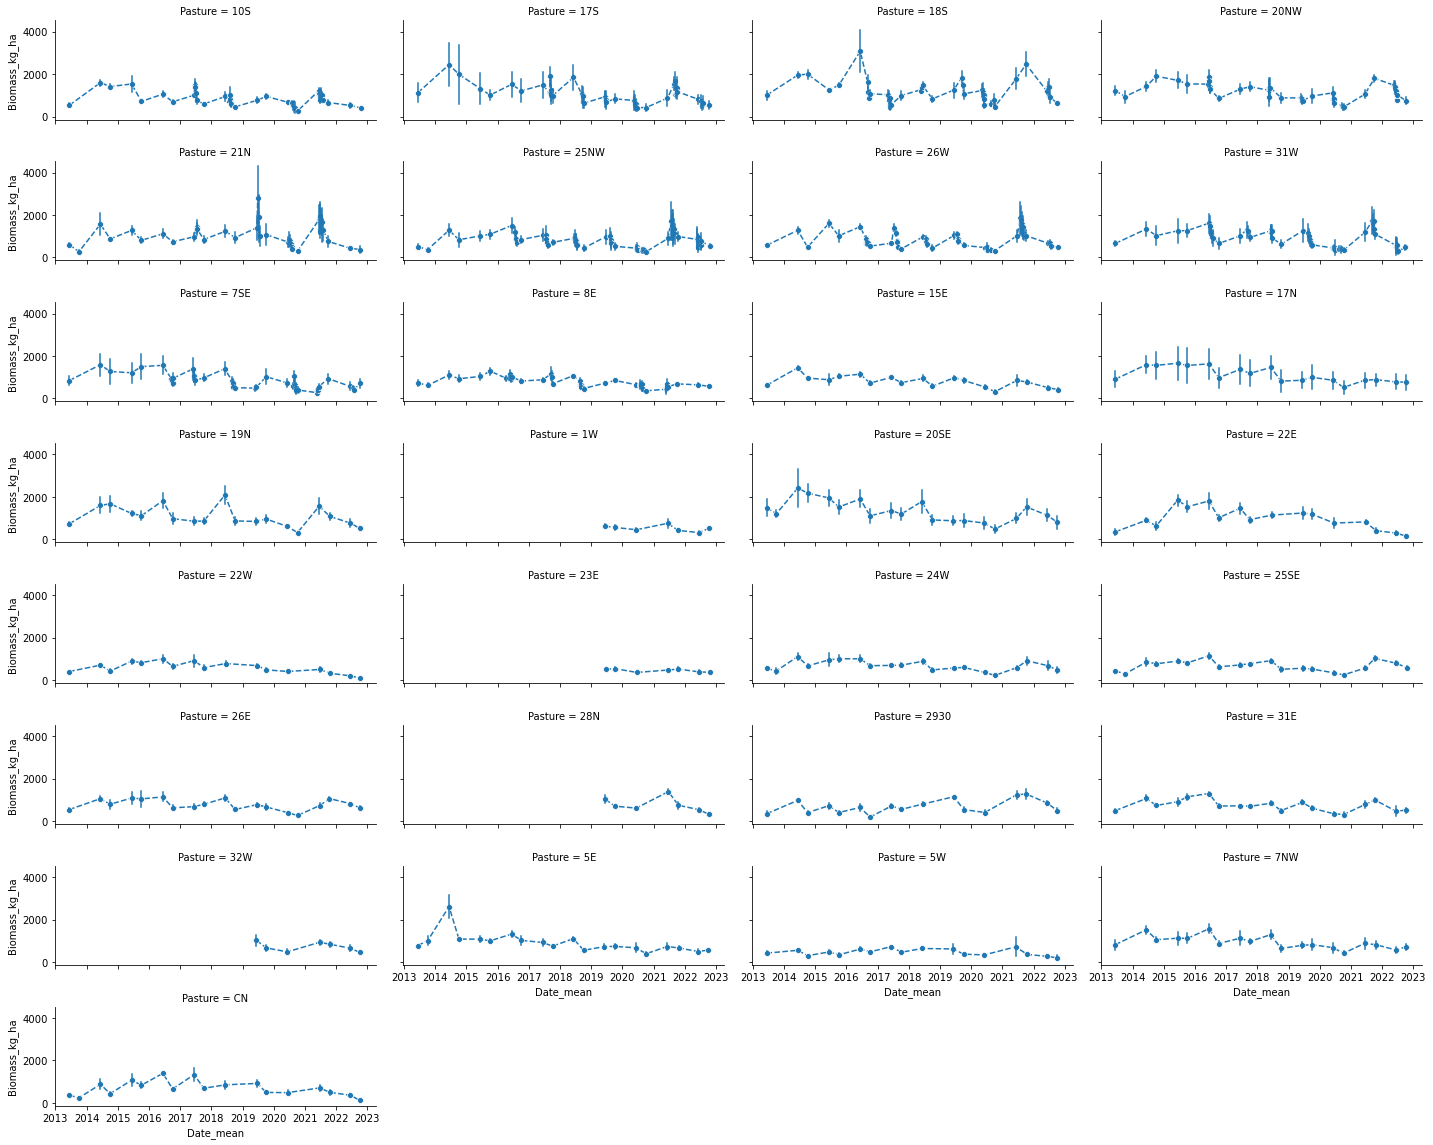

In [18]:
sns.relplot(x='Date_mean', y='Biomass_kg_ha', col='Pasture', col_wrap=4, kind='line', 
            errorbar='sd', err_style='bars', marker='o', linestyle='dashed', data=df_vor_fnl, 
                height=2, aspect=2.5)
#sns.move_legend(p, "upper center", ncol=10)

#### Save to disk

In [19]:
from datetime import datetime

In [20]:
save_cols = ['Id', 'Pasture', 'Date', 'Date_mean', 'Year', 'Season', 'Low', 'High', 'Biomass_kg_ha', 'geometry']
yrs_dat = '_'.join(df_vor_fnl['Year'].agg(['min', 'max']).astype('str'))
df_vor_fnl[save_cols].to_csv('data/ground_cln/vor_' + yrs_dat + '_cln_' + datetime.now().strftime('%Y_%m_%d') + '_' + exp_unit + '.csv',
                  index=False)